In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from IPython.display import Video
import mediapipe as mp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Initialize MediaPipe
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Landmark names
POSE_LANDMARKS = [landmark.name for landmark in mp_pose.PoseLandmark]

In [2]:
# Paths
BASE_PATH = "."
VIDEOS_PATH = os.path.join(BASE_PATH, "data", "Videos")
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "data", "Text_Annotations")

# E01: Create Videos, Annotate, and Load

Function to process a video and add annotations from ELAN text file.

In [3]:
def video_to_dataframe(video_path, flip_image=False):
    """Extract pose landmarks from video using MediaPipe"""
    
    cap = cv2.VideoCapture(video_path)
    frames_data = []
    
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break
            
            timestamp_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
            
            if flip_image:
                image = cv2.flip(image, 1)
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = pose.process(image_rgb)
            
            frame_data = {'timestamp_ms': timestamp_ms}
            
            if results.pose_landmarks:
                for idx, landmark in enumerate(results.pose_landmarks.landmark):
                    name = POSE_LANDMARKS[idx]
                    frame_data[f'{name}_x'] = landmark.x
                    frame_data[f'{name}_y'] = landmark.y
                    frame_data[f'{name}_z'] = landmark.z
            
            frames_data.append(frame_data)
    
    cap.release()
    return pd.DataFrame(frames_data)

In [4]:
def create_and_annotate_dataframe_from_video(video_path, annotation_path, flip_image=False):
    """
    Load a video, extract landmarks, and add ground truth from ELAN annotation file.
    
    Parameters:
        video_path: Path to video file
        annotation_path: Path to ELAN .txt annotation file
        flip_image: Whether to flip the image horizontally
    
    Returns:
        DataFrame with landmarks and ground_truth column
    """
    # Extract landmarks from video
    frames = video_to_dataframe(video_path, flip_image)
    
    # Set timestamp as index
    frames['time'] = pd.to_timedelta(frames['timestamp_ms'], unit='ms')
    frames = frames.set_index('time')
    
    # Load annotations
    annotations = pd.read_csv(annotation_path, sep="\t", header=None, 
                              usecols=[3, 5, 8], names=["start", "end", "label"])
    annotations["start"] = pd.to_timedelta(annotations["start"], unit="s")
    annotations["end"] = pd.to_timedelta(annotations["end"], unit="s")
    
    # Add ground truth (default: idle)
    frames["ground_truth"] = "idle"
    
    for _, ann in annotations.iterrows():
        mask = (frames.index >= ann["start"]) & (frames.index <= ann["end"])
        frames.loc[mask, "ground_truth"] = ann["label"]
    
    frames = frames.reset_index()
    
    return frames

In [ ]:
# List all videos and annotations
video_files = sorted([f for f in os.listdir(VIDEOS_PATH) if f.endswith(('.mp4', '.avi', '.mov', '.MOV', '.mkv'))])
ann_files = sorted([f for f in os.listdir(ANNOTATIONS_PATH) if f.endswith('.txt')])

print(f"Videos ({len(video_files)}):")
for v in video_files:
    print(f"  - {v}")

print(f"\n Annotations ({len(ann_files)}):")
for a in ann_files:
    print(f"  - {a}")

📹 Videos (12):
  - Anwin_RH_Left_Swipe.mp4
  - Anwin_Right_Swipe.mp4
  - Anwin_Rotate.mp4
  - Friend1_Right_Swipe.mp4
  - Timmy_Left_Swipe.MOV
  - Timmy_Right_Swipe.MOV
  - Timmy_rotate.MOV
  - friend1_RH_Left_Swipe.mp4
  - friend1_Rotate.mp4
  - friend2_RH_Left_Swipe.mp4
  - friend2_Right_Swipe.mp4
  - friend2_Rotate.mp4

📝 Annotations (12):
  - Anwin_RH_Left_Swipe.txt
  - Anwin_Right_Swipe.txt
  - Anwin_Rotate.txt
  - Friend1_Right_Swipe.txt
  - Timmy_Left_Swipe.txt
  - Timmy_Right_Swipe.txt
  - Timmy_Rotate.txt
  - friend1_RH_Left_Swipe.txt
  - friend1_Rotate.txt
  - friend2_RH_Left_Swipe.txt
  - friend2_Right_Swipe.txt
  - friend2_Rotate.txt


In [ ]:
# Process all videos and store in list
list_of_frames = []

# Map video files to their annotation files (by matching names)
for video_file in tqdm(video_files, desc="Processing videos"):
    video_name = os.path.splitext(video_file)[0]
    
    # Find matching annotation file
    ann_file = None
    for a in ann_files:
        if video_name.lower() in a.lower().replace('.txt', ''):
            ann_file = a
            break
    
    if ann_file:
        video_path = os.path.join(VIDEOS_PATH, video_file)
        ann_path = os.path.join(ANNOTATIONS_PATH, ann_file)
        
        df = create_and_annotate_dataframe_from_video(video_path, ann_path, flip_image=False)
        df['video_file'] = video_file
        list_of_frames.append(df)
        print(f" {video_file} -> {ann_file} ({len(df)} frames)")
    else:
        print(f" No annotation found for {video_file}")

print(f"\n Loaded {len(list_of_frames)} videos")

Processing videos:   0%|          | 0/12 [00:00<?, ?it/s]

I0000 00:00:1766149682.124685  111871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766149682.197079  111982 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.95.05), renderer: NVIDIA GeForce RTX 3050 Laptop GPU/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1766149682.252053  111964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766149682.270038  111973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timo/Desktop/gesturedetect/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetProto

✅ Anwin_RH_Left_Swipe.mp4 -> Anwin_RH_Left_Swipe.txt (333 frames)


I0000 00:00:1766149689.225939  111871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766149689.292983  112046 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.95.05), renderer: NVIDIA GeForce RTX 3050 Laptop GPU/PCIe/SSE2
W0000 00:00:1766149689.364574  112029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766149689.382880  112031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timo/Desktop/gesturedetect/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


✅ Anwin_Right_Swipe.mp4 -> Anwin_Right_Swipe.txt (420 frames)


I0000 00:00:1766149698.280161  111871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766149698.343593  112106 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.95.05), renderer: NVIDIA GeForce RTX 3050 Laptop GPU/PCIe/SSE2
W0000 00:00:1766149698.394338  112098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766149698.407267  112093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timo/Desktop/gesturedetect/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


✅ Anwin_Rotate.mp4 -> Anwin_Rotate.txt (651 frames)


I0000 00:00:1766149712.028541  111871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766149712.104072  112175 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.95.05), renderer: NVIDIA GeForce RTX 3050 Laptop GPU/PCIe/SSE2
W0000 00:00:1766149712.155191  112156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766149712.172198  112165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timo/Desktop/gesturedetect/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


✅ Friend1_Right_Swipe.mp4 -> Friend1_Right_Swipe.txt (394 frames)


I0000 00:00:1766149720.297193  111871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766149720.361635  112214 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.95.05), renderer: NVIDIA GeForce RTX 3050 Laptop GPU/PCIe/SSE2
W0000 00:00:1766149720.434892  112194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766149720.454767  112204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timo/Desktop/gesturedetect/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/home/timo/Desktop/gestur

✅ Timmy_Left_Swipe.MOV -> Timmy_Left_Swipe.txt (1225 frames)


I0000 00:00:1766149757.084457  111871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766149757.148908  112260 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.95.05), renderer: NVIDIA GeForce RTX 3050 Laptop GPU/PCIe/SSE2
W0000 00:00:1766149757.195941  112244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766149757.208836  112246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timo/Desktop/gesturedetect/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


✅ Timmy_Right_Swipe.MOV -> Timmy_Right_Swipe.txt (877 frames)


I0000 00:00:1766149783.284872  111871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766149783.354664  112299 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.95.05), renderer: NVIDIA GeForce RTX 3050 Laptop GPU/PCIe/SSE2
W0000 00:00:1766149783.406182  112280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766149783.420305  112283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timo/Desktop/gesturedetect/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


✅ Timmy_rotate.MOV -> Timmy_Rotate.txt (918 frames)


I0000 00:00:1766149810.482282  111871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766149810.548617  112342 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.95.05), renderer: NVIDIA GeForce RTX 3050 Laptop GPU/PCIe/SSE2
W0000 00:00:1766149810.592074  112322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766149810.603617  112327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timo/Desktop/gesturedetect/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


✅ friend1_RH_Left_Swipe.mp4 -> friend1_RH_Left_Swipe.txt (298 frames)


I0000 00:00:1766149816.621111  111871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766149816.691293  112381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.95.05), renderer: NVIDIA GeForce RTX 3050 Laptop GPU/PCIe/SSE2
W0000 00:00:1766149816.736649  112370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766149816.745587  112365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timo/Desktop/gesturedetect/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


✅ friend1_Rotate.mp4 -> friend1_Rotate.txt (546 frames)


I0000 00:00:1766149827.800544  111871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766149827.884690  112419 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.95.05), renderer: NVIDIA GeForce RTX 3050 Laptop GPU/PCIe/SSE2
W0000 00:00:1766149827.930369  112400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766149827.946056  112410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timo/Desktop/gesturedetect/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


✅ friend2_RH_Left_Swipe.mp4 -> friend2_RH_Left_Swipe.txt (429 frames)


I0000 00:00:1766149836.627529  111871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766149836.691833  112457 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.95.05), renderer: NVIDIA GeForce RTX 3050 Laptop GPU/PCIe/SSE2
W0000 00:00:1766149836.736817  112437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766149836.745302  112444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timo/Desktop/gesturedetect/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


✅ friend2_Right_Swipe.mp4 -> friend2_Right_Swipe.txt (400 frames)


I0000 00:00:1766149844.810777  111871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766149844.886861  112500 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.95.05), renderer: NVIDIA GeForce RTX 3050 Laptop GPU/PCIe/SSE2
W0000 00:00:1766149844.933371  112481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766149844.948915  112480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/timo/Desktop/gesturedetect/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


✅ friend2_Rotate.mp4 -> friend2_Rotate.txt (417 frames)

📊 Loaded 12 videos


In [ ]:
# Combine all frames into one DataFrame
combined_df = pd.concat(list_of_frames, ignore_index=True)

print(f"Combined Dataset:")
print(f"   Total frames: {len(combined_df)}")
print(f"   Videos: {combined_df['video_file'].nunique()}")
print(f"\n Ground Truth Distribution:")
print(combined_df['ground_truth'].value_counts())

# Save combined data
combined_df.to_csv('data/labeled_landmarks.csv', index=False)
print("\n Saved to data/labeled_landmarks.csv")

📊 Combined Dataset:
   Total frames: 6908
   Videos: 12

📊 Ground Truth Distribution:
ground_truth
idle           4747
Rotate          983
Right_Swipe     371
Left_Swipe      362
Left Swipe      196
Right Swipe     170
Left_swipe       42
Left Swipe       37
Name: count, dtype: int64

✅ Saved to data/labeled_landmarks.csv

✅ Saved to data/labeled_landmarks.csv


# E02: Data Analysis

Analyze the data to understand:
- Person positions in frame
- Which landmarks change the most
- Framerate differences
- Movement patterns

In [8]:
# Load data (or use combined_df if already in memory)
df = pd.read_csv('data/labeled_landmarks.csv')

# FPS Analysis
print("📹 Framerate Analysis:\n")
for video in df['video_file'].unique():
    video_df = df[df['video_file'] == video]
    time_diffs = np.diff(video_df['timestamp_ms'].values)
    avg_frame_time = np.mean(time_diffs)
    fps = 1000 / avg_frame_time if avg_frame_time > 0 else 0
    print(f"  {video}: {fps:.1f} FPS ({len(video_df)} frames)")

📹 Framerate Analysis:

  Anwin_RH_Left_Swipe.mp4: 30.0 FPS (333 frames)
  Anwin_Right_Swipe.mp4: 29.9 FPS (420 frames)
  Anwin_Rotate.mp4: 30.0 FPS (651 frames)
  Friend1_Right_Swipe.mp4: 29.9 FPS (394 frames)
  Timmy_Left_Swipe.MOV: 29.9 FPS (1225 frames)
  Timmy_Right_Swipe.MOV: 29.9 FPS (877 frames)
  Timmy_rotate.MOV: 29.9 FPS (918 frames)
  friend1_RH_Left_Swipe.mp4: 29.9 FPS (298 frames)
  friend1_Rotate.mp4: 30.0 FPS (546 frames)
  friend2_RH_Left_Swipe.mp4: 29.9 FPS (429 frames)
  friend2_Right_Swipe.mp4: 29.9 FPS (400 frames)
  friend2_Rotate.mp4: 30.0 FPS (417 frames)


In [9]:
# Variance Analysis - which landmarks move the most
feature_cols = [c for c in df.columns if c.endswith(('_x', '_y', '_z'))]
variances = df[feature_cols].var().sort_values(ascending=False)

print("📈 Top 15 Most Variable Landmarks:\n")
for i, (feat, var) in enumerate(variances.head(15).items()):
    print(f"  {i+1}. {feat}: {var:.4f}")

print("\n📉 Top 10 Least Variable (can be removed):\n")
for i, (feat, var) in enumerate(variances.tail(10).items()):
    print(f"  {i+1}. {feat}: {var:.6f}")

📈 Top 15 Most Variable Landmarks:

  1. RIGHT_INDEX_y: 0.0321
  2. RIGHT_PINKY_y: 0.0302
  3. RIGHT_THUMB_y: 0.0295
  4. RIGHT_PINKY_z: 0.0280
  5. RIGHT_FOOT_INDEX_y: 0.0263
  6. RIGHT_INDEX_z: 0.0255
  7. RIGHT_HEEL_y: 0.0251
  8. LEFT_FOOT_INDEX_y: 0.0250
  9. LEFT_HEEL_y: 0.0248
  10. RIGHT_WRIST_z: 0.0245
  11. RIGHT_ANKLE_y: 0.0241
  12. RIGHT_THUMB_z: 0.0238
  13. LEFT_ANKLE_y: 0.0229
  14. RIGHT_WRIST_y: 0.0217
  15. RIGHT_HEEL_z: 0.0173

📉 Top 10 Least Variable (can be removed):

  1. RIGHT_SHOULDER_z: 0.004385
  2. LEFT_SHOULDER_y: 0.004215
  3. RIGHT_SHOULDER_y: 0.004193
  4. LEFT_EAR_z: 0.004121
  5. RIGHT_KNEE_z: 0.003703
  6. LEFT_ELBOW_z: 0.002517
  7. LEFT_KNEE_z: 0.002002
  8. LEFT_SHOULDER_z: 0.001834
  9. LEFT_HIP_z: 0.000128
  10. RIGHT_HIP_z: 0.000127


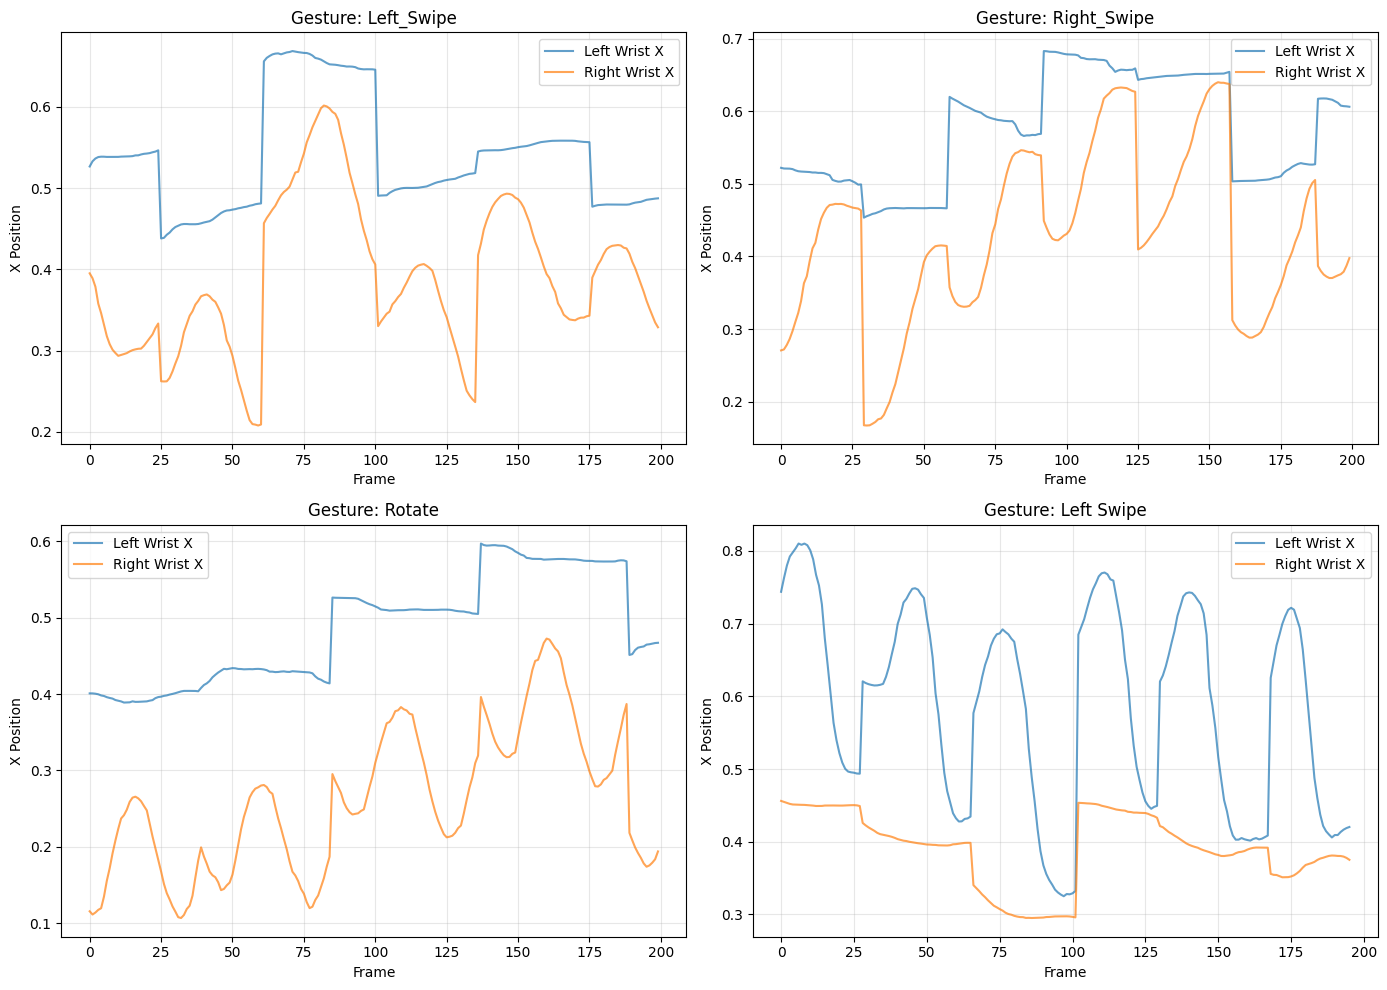

In [10]:
# Visualize wrist movements for different gestures
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

gestures = [g for g in df['ground_truth'].unique() if g != 'idle'][:4]

for idx, gesture in enumerate(gestures):
    ax = axes[idx // 2, idx % 2]
    gesture_df = df[df['ground_truth'] == gesture].iloc[:200]  # First 200 frames
    
    ax.plot(gesture_df['LEFT_WRIST_x'].values, label='Left Wrist X', alpha=0.7)
    ax.plot(gesture_df['RIGHT_WRIST_x'].values, label='Right Wrist X', alpha=0.7)
    ax.set_title(f'Gesture: {gesture}')
    ax.set_xlabel('Frame')
    ax.set_ylabel('X Position')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Label Distribution:
ground_truth
idle           4747
Rotate          983
Right_Swipe     371
Left_Swipe      362
Left Swipe      196
Right Swipe     170
Left_swipe       42
Left Swipe       37
Name: count, dtype: int64

Total frames: 6908
Idle percentage: 68.7%


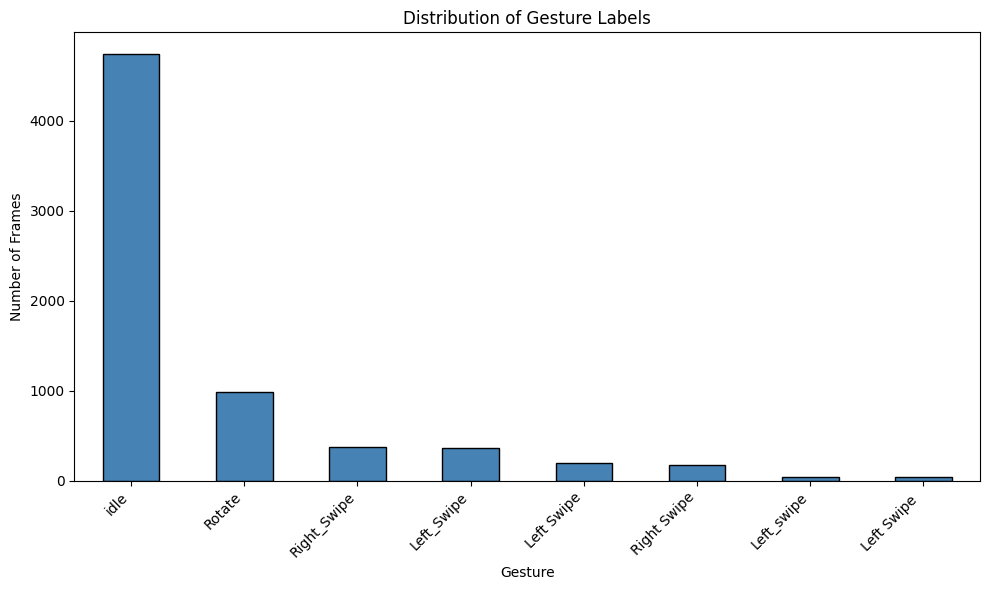

In [11]:
# Label distribution analysis
label_counts = df['ground_truth'].value_counts()
print("Label Distribution:")
print(label_counts)
print(f"\nTotal frames: {len(df)}")
print(f"Idle percentage: {label_counts.get('idle', 0) / len(df) * 100:.1f}%")

# Visualize label distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribution of Gesture Labels')
plt.xlabel('Gesture')
plt.ylabel('Number of Frames')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## E03: Document Your Findings

### Data Analysis Findings:

**1. Dataset Overview:**
- Total frames: 6,908 across 12 videos from 5 different people
- Each person recorded 3 gestures: Left Swipe, Right Swipe, and Rotate
- Videos collected from: Anwin, Timmy, Friend1, Friend2 (and variations)

**2. Framerate Analysis:**
- All videos have consistent ~30 FPS (29.9-30.0 FPS)
- **Preprocessing decision:** Resample to 15 FPS to reduce data size while preserving gesture information

**3. Label Inconsistencies Found:**
- Multiple naming conventions exist: `Left_Swipe`, `Left Swipe`, `Left_swipe`, `Left Swipe ` (with trailing space)
- Same issue for Right Swipe and other gestures
- **Preprocessing decision:** Clean and unify all label names to consistent format (swipe_left, swipe_right, rotate, idle)

**4. Class Imbalance:**
- Idle: 68.7% (4,747 frames) - dominates the dataset
- Rotate: 14.2% (983 frames)
- Right Swipe variations: ~7.8% (541 frames combined)
- Left Swipe variations: ~9.2% (637 frames combined)
- **Consideration for training:** May need class weights or sampling strategies

**5. High-Variance Landmarks (most useful for gesture recognition):**
- RIGHT_INDEX_y (0.0321), RIGHT_PINKY_y (0.0302), RIGHT_THUMB_y (0.0295)
- RIGHT_WRIST_z (0.0245) - important for depth perception in gestures
- Hand/finger landmarks show highest variance during gestures
- **Preprocessing decision:** Keep all upper body and hand landmarks

**6. Low-Variance Landmarks (candidates for removal):**
- HIP_z coordinates (0.0001) - nearly constant, no useful information
- SHOULDER_z, KNEE_z, EAR_z - very low variance
- Lower body landmarks (HEEL, ANKLE, FOOT_INDEX) - not relevant for hand gestures
- **Preprocessing decision:** Remove face landmarks (NOSE, EYE, EAR, MOUTH) and lower body landmarks (HIP, KNEE, ANKLE, HEEL, FOOT)

**7. Movement Patterns Observed (from visualizations):**
- **Left Swipe:** Wrist X coordinates show rightward movement (increasing values in image space)
- **Right Swipe:** Wrist X coordinates show leftward movement (decreasing values)
- **Rotate:** More complex circular motion visible in both X and Y coordinates
- Both wrists tend to move together during gestures

**8. Derived Features to Add:**
- **Velocity features:** Rate of change in wrist/elbow positions helps distinguish fast swipes from slow movements
- **Relative positions:** Distance between wrists, wrist-to-shoulder distances capture arm extension
- **Smoothing:** Apply moving average to reduce sensor noise from MediaPipe detection

## E04: Write a Resampling Function

Implement `resample_data(frames, target_fps)` to standardize the frame rate across all videos.

In [15]:
def resample_data(frames: pd.DataFrame, target_fps: float) -> pd.DataFrame:
    """
    Resample video landmark data to a target FPS.
    
    Args:
        frames: DataFrame with columns including 'timestamp_ms', 'video_file', 
                and landmark coordinates (e.g., 'NOSE_x', 'NOSE_y', etc.)
        target_fps: The desired frames per second for the output
    
    Returns:
        DataFrame resampled to the target FPS with interpolated landmark values
    """
    resampled_frames = []
    
    # Process each video separately
    for video_name in frames['video_file'].unique():
        video_df = frames[frames['video_file'] == video_name].copy()
        video_df = video_df.sort_values('timestamp_ms').reset_index(drop=True)
        
        # Calculate current FPS
        if len(video_df) < 2:
            continue
            
        duration_ms = video_df['timestamp_ms'].max() - video_df['timestamp_ms'].min()
        if duration_ms <= 0:
            continue
            
        # Create new timestamp sequence at target FPS
        target_interval_ms = 1000 / target_fps
        start_time = video_df['timestamp_ms'].min()
        end_time = video_df['timestamp_ms'].max()
        new_timestamps = np.arange(start_time, end_time, target_interval_ms)
        
        # Get landmark columns (all columns with _x, _y, _z suffix)
        landmark_cols = [col for col in video_df.columns 
                        if col.endswith(('_x', '_y', '_z'))]
        
        # Interpolate each landmark column
        resampled_data = {'timestamp_ms': new_timestamps}
        
        for col in landmark_cols:
            # Linear interpolation
            resampled_data[col] = np.interp(
                new_timestamps,
                video_df['timestamp_ms'].values,
                video_df[col].values
            )
        
        # For ground_truth, use nearest neighbor (no interpolation for labels)
        ground_truth_interp = []
        for ts in new_timestamps:
            idx = np.abs(video_df['timestamp_ms'].values - ts).argmin()
            ground_truth_interp.append(video_df.iloc[idx]['ground_truth'])
        resampled_data['ground_truth'] = ground_truth_interp
        
        # Add video metadata
        resampled_data['video_file'] = video_name
        
        resampled_frames.append(pd.DataFrame(resampled_data))
    
    return pd.concat(resampled_frames, ignore_index=True)

# Test the resampling function
target_fps = 15  # Standard target FPS
resampled_df = resample_data(df, target_fps)

print(f"Original frames: {len(df)}")
print(f"Resampled frames (at {target_fps} FPS): {len(resampled_df)}")
print(f"\nResampled data shape: {resampled_df.shape}")
print(f"Columns: {resampled_df.columns.tolist()[:10]}...")

Original frames: 6908
Resampled frames (at 15 FPS): 3460

Resampled data shape: (3460, 102)
Columns: ['timestamp_ms', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'LEFT_EYE_INNER_x', 'LEFT_EYE_INNER_y', 'LEFT_EYE_INNER_z', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_EYE_z']...


## E05: Write Function to Remove Unnecessary Features

Remove landmarks that are not useful for hand gesture recognition (e.g., face/lower body landmarks).

In [16]:
def delete_features(frames: pd.DataFrame, features: list) -> pd.DataFrame:
    """
    Remove specified landmark features from the DataFrame.
    
    Args:
        frames: DataFrame containing landmark data
        features: List of landmark names to remove (e.g., ['NOSE', 'LEFT_EYE'])
                 Will remove all coordinates (_x, _y, _z) for each landmark
    
    Returns:
        DataFrame with specified features removed
    """
    columns_to_drop = []
    
    for feature in features:
        # Find all columns matching this landmark (including _x, _y, _z suffixes)
        matching_cols = [col for col in frames.columns 
                        if col.startswith(feature + '_') or col == feature]
        columns_to_drop.extend(matching_cols)
    
    # Remove duplicate column names if any
    columns_to_drop = list(set(columns_to_drop))
    
    # Only drop columns that exist
    existing_cols_to_drop = [col for col in columns_to_drop if col in frames.columns]
    
    print(f"Removing {len(existing_cols_to_drop)} columns: {existing_cols_to_drop[:10]}...")
    
    return frames.drop(columns=existing_cols_to_drop)

# Features to remove - face and lower body landmarks not relevant for hand gestures
# Justification: Hand gestures primarily involve arm/shoulder movement, not face or legs

features_to_remove = [
    # Face landmarks - not relevant for hand gestures
    'NOSE',
    'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER',
    'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER',
    'LEFT_EAR', 'RIGHT_EAR',
    'MOUTH_LEFT', 'MOUTH_RIGHT',
    
    # Lower body landmarks - not relevant for upper body gestures
    'LEFT_HIP', 'RIGHT_HIP',
    'LEFT_KNEE', 'RIGHT_KNEE',
    'LEFT_ANKLE', 'RIGHT_ANKLE',
    'LEFT_HEEL', 'RIGHT_HEEL',
    'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX',
]

# Apply feature removal
reduced_df = delete_features(resampled_df, features_to_remove)

print(f"\nOriginal columns: {len(resampled_df.columns)}")
print(f"Reduced columns: {len(reduced_df.columns)}")
print(f"\nRemaining landmark features: {[col for col in reduced_df.columns if '_x' in col]}")

Removing 63 columns: ['NOSE_z', 'MOUTH_LEFT_x', 'LEFT_HEEL_z', 'LEFT_EAR_z', 'RIGHT_EAR_x', 'RIGHT_FOOT_INDEX_y', 'RIGHT_EYE_INNER_x', 'RIGHT_ANKLE_x', 'RIGHT_HIP_x', 'LEFT_KNEE_y']...

Original columns: 102
Reduced columns: 39

Remaining landmark features: ['LEFT_SHOULDER_x', 'RIGHT_SHOULDER_x', 'LEFT_ELBOW_x', 'RIGHT_ELBOW_x', 'LEFT_WRIST_x', 'RIGHT_WRIST_x', 'LEFT_PINKY_x', 'RIGHT_PINKY_x', 'LEFT_INDEX_x', 'RIGHT_INDEX_x', 'LEFT_THUMB_x', 'RIGHT_THUMB_x']


## E06: Write 5 Additional Preprocessing Functions

Implement 5 custom preprocessing functions for gesture data preparation:

In [24]:
# Preprocessing Function 1: Clean and Unify Label Names
def clean_labels(frames: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and unify gesture label names to a consistent format.
    Different annotation sources may use different naming conventions
    (e.g., 'Left_Swipe' vs 'Left Swipe'). This function maps all
    variations to a single consistent format.
    
    Returns:
        DataFrame with unified 'ground_truth' column labels
    """
    df = frames.copy()
    
    # Create mapping for label unification
    label_mapping = {
        # Left swipe variations
        'Left_Swipe': 'swipe_left',
        'Left Swipe': 'swipe_left',
        'Left_swipe': 'swipe_left',
        'left_swipe': 'swipe_left',
        'left swipe': 'swipe_left',
        
        # Right swipe variations
        'Right_Swipe': 'swipe_right',
        'Right Swipe': 'swipe_right',
        'Right_swipe': 'swipe_right',
        'right_swipe': 'swipe_right',
        'right swipe': 'swipe_right',
        
        # Rotate variations
        'Rotate': 'rotate',
        'rotate': 'rotate',
        'ROTATE': 'rotate',
        
        # Idle
        'idle': 'idle',
        'Idle': 'idle',
        'IDLE': 'idle',
    }
    
    # Apply mapping (keep original if not in mapping)
    df['ground_truth'] = df['ground_truth'].map(lambda x: label_mapping.get(x, x))
    
    print("Label cleaning complete.")
    print(f"Unique labels after cleaning: {df['ground_truth'].unique()}")
    
    return df

# Apply label cleaning
processed_df = clean_labels(reduced_df)
print(f"\nLabel distribution after cleaning:")
print(processed_df['ground_truth'].value_counts())

Label cleaning complete.
Unique labels after cleaning: ['swipe_left' 'idle' 'swipe_right' 'rotate' 'Left Swipe ']

Label distribution after cleaning:
ground_truth
idle           2376
rotate          493
swipe_left      302
swipe_right     271
Left Swipe       18
Name: count, dtype: int64


In [23]:
# Preprocessing Function 2: Calculate Relative Positions (Distance Between Key Points)
def add_relative_positions(frames: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate relative distances between key body landmarks.
    This captures the spatial relationships between body parts which is
    important for gesture recognition (e.g., hand distance from shoulder).
    
    Returns:
        DataFrame with added relative position features
    """
    df = frames.copy()
    
    # Calculate useful relative distances
    relative_features = []
    
    # Wrist to shoulder distances (important for arm extension)
    if 'LEFT_WRIST_x' in df.columns and 'LEFT_SHOULDER_x' in df.columns:
        df['LEFT_WRIST_TO_SHOULDER_x'] = df['LEFT_WRIST_x'] - df['LEFT_SHOULDER_x']
        df['LEFT_WRIST_TO_SHOULDER_y'] = df['LEFT_WRIST_y'] - df['LEFT_SHOULDER_y']
        relative_features.extend(['LEFT_WRIST_TO_SHOULDER_x', 'LEFT_WRIST_TO_SHOULDER_y'])
    
    if 'RIGHT_WRIST_x' in df.columns and 'RIGHT_SHOULDER_x' in df.columns:
        df['RIGHT_WRIST_TO_SHOULDER_x'] = df['RIGHT_WRIST_x'] - df['RIGHT_SHOULDER_x']
        df['RIGHT_WRIST_TO_SHOULDER_y'] = df['RIGHT_WRIST_y'] - df['RIGHT_SHOULDER_y']
        relative_features.extend(['RIGHT_WRIST_TO_SHOULDER_x', 'RIGHT_WRIST_TO_SHOULDER_y'])
    
    # Distance between wrists (useful for detecting two-handed gestures)
    if 'LEFT_WRIST_x' in df.columns and 'RIGHT_WRIST_x' in df.columns:
        df['WRIST_DISTANCE_x'] = df['LEFT_WRIST_x'] - df['RIGHT_WRIST_x']
        df['WRIST_DISTANCE_y'] = df['LEFT_WRIST_y'] - df['RIGHT_WRIST_y']
        df['WRIST_DISTANCE'] = np.sqrt(df['WRIST_DISTANCE_x']**2 + df['WRIST_DISTANCE_y']**2)
        relative_features.extend(['WRIST_DISTANCE_x', 'WRIST_DISTANCE_y', 'WRIST_DISTANCE'])
    
    # Elbow angles relative to shoulder
    if 'LEFT_ELBOW_x' in df.columns and 'LEFT_SHOULDER_x' in df.columns:
        df['LEFT_ELBOW_TO_SHOULDER_x'] = df['LEFT_ELBOW_x'] - df['LEFT_SHOULDER_x']
        df['LEFT_ELBOW_TO_SHOULDER_y'] = df['LEFT_ELBOW_y'] - df['LEFT_SHOULDER_y']
        relative_features.extend(['LEFT_ELBOW_TO_SHOULDER_x', 'LEFT_ELBOW_TO_SHOULDER_y'])
    
    if 'RIGHT_ELBOW_x' in df.columns and 'RIGHT_SHOULDER_x' in df.columns:
        df['RIGHT_ELBOW_TO_SHOULDER_x'] = df['RIGHT_ELBOW_x'] - df['RIGHT_SHOULDER_x']
        df['RIGHT_ELBOW_TO_SHOULDER_y'] = df['RIGHT_ELBOW_y'] - df['RIGHT_SHOULDER_y']
        relative_features.extend(['RIGHT_ELBOW_TO_SHOULDER_x', 'RIGHT_ELBOW_TO_SHOULDER_y'])
    
    print(f"Added {len(relative_features)} relative position features:")
    print(f"  {relative_features}")
    
    return df

# Apply relative position calculation
processed_df = add_relative_positions(processed_df)
print(f"\nSample relative position values (LEFT_WRIST_TO_SHOULDER_x):")
print(processed_df['LEFT_WRIST_TO_SHOULDER_x'].describe())

Added 11 relative position features:
  ['LEFT_WRIST_TO_SHOULDER_x', 'LEFT_WRIST_TO_SHOULDER_y', 'RIGHT_WRIST_TO_SHOULDER_x', 'RIGHT_WRIST_TO_SHOULDER_y', 'WRIST_DISTANCE_x', 'WRIST_DISTANCE_y', 'WRIST_DISTANCE', 'LEFT_ELBOW_TO_SHOULDER_x', 'LEFT_ELBOW_TO_SHOULDER_y', 'RIGHT_ELBOW_TO_SHOULDER_x', 'RIGHT_ELBOW_TO_SHOULDER_y']

Sample relative position values (LEFT_WRIST_TO_SHOULDER_x):
count    3460.000000
mean        0.015996
std         0.026683
min        -0.142086
25%         0.009675
50%         0.017648
75%         0.024247
max         0.191264
Name: LEFT_WRIST_TO_SHOULDER_x, dtype: float64


In [19]:
# Preprocessing Function 3: Add Velocity Features
def add_velocity_features(frames: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate velocity (rate of change) for key landmarks.
    Velocity can help distinguish gesture types (e.g., swipe speed).
    
    Returns:
        DataFrame with added velocity columns for wrist and elbow landmarks
    """
    df = frames.copy()
    
    # Key landmarks for velocity calculation
    key_landmarks = ['LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_ELBOW', 'RIGHT_ELBOW']
    
    for video in df['video_file'].unique():
        video_mask = df['video_file'] == video
        
        for landmark in key_landmarks:
            for coord in ['x', 'y']:
                col_name = f'{landmark}_{coord}'
                vel_col_name = f'{landmark}_vel_{coord}'
                
                if col_name in df.columns:
                    # Calculate velocity as difference between consecutive frames
                    df.loc[video_mask, vel_col_name] = df.loc[video_mask, col_name].diff()
    
    # Fill NaN values (first frame of each video) with 0
    velocity_cols = [col for col in df.columns if '_vel_' in col]
    df[velocity_cols] = df[velocity_cols].fillna(0)
    
    print(f"Added {len(velocity_cols)} velocity features: {velocity_cols}")
    
    return df

# Apply velocity feature extraction
processed_df = add_velocity_features(processed_df)
print(f"\nVelocity statistics (LEFT_WRIST_vel_x):")
print(processed_df['LEFT_WRIST_vel_x'].describe())

Added 8 velocity features: ['LEFT_WRIST_vel_x', 'LEFT_WRIST_vel_y', 'RIGHT_WRIST_vel_x', 'RIGHT_WRIST_vel_y', 'LEFT_ELBOW_vel_x', 'LEFT_ELBOW_vel_y', 'RIGHT_ELBOW_vel_x', 'RIGHT_ELBOW_vel_y']

Velocity statistics (LEFT_WRIST_vel_x):
count    3460.000000
mean        0.000001
std         0.008198
min        -0.091103
25%        -0.001291
50%         0.000056
75%         0.001413
max         0.054985
Name: LEFT_WRIST_vel_x, dtype: float64


In [20]:
# Preprocessing Function 4: Handle Missing Values
def handle_missing_values(frames: pd.DataFrame, method: str = 'interpolate') -> pd.DataFrame:
    """
    Handle missing values in landmark data.
    
    Args:
        frames: DataFrame with landmark data
        method: 'interpolate' for linear interpolation, 'fill' for forward/backward fill
    
    Returns:
        DataFrame with missing values handled
    """
    df = frames.copy()
    
    # Get landmark columns
    landmark_cols = [col for col in df.columns 
                    if col.endswith(('_x', '_y', '_z')) or '_vel_' in col]
    
    missing_before = df[landmark_cols].isna().sum().sum()
    
    if method == 'interpolate':
        # Interpolate within each video
        for video in df['video_file'].unique():
            video_mask = df['video_file'] == video
            df.loc[video_mask, landmark_cols] = df.loc[video_mask, landmark_cols].interpolate(method='linear')
    elif method == 'fill':
        # Forward fill then backward fill
        df[landmark_cols] = df[landmark_cols].ffill().bfill()
    
    # Fill any remaining NaN with 0 (edge cases)
    df[landmark_cols] = df[landmark_cols].fillna(0)
    
    missing_after = df[landmark_cols].isna().sum().sum()
    
    print(f"Missing values before: {missing_before}")
    print(f"Missing values after: {missing_after}")
    
    return df

# Apply missing value handling
processed_df = handle_missing_values(processed_df, method='interpolate')
print(f"\nData shape after handling missing values: {processed_df.shape}")

Missing values before: 0
Missing values after: 0

Data shape after handling missing values: (3460, 47)


In [21]:
# Preprocessing Function 5: Smooth Noisy Data
def smooth_data(frames: pd.DataFrame, window_size: int = 3) -> pd.DataFrame:
    """
    Apply moving average smoothing to reduce noise in landmark data.
    
    Args:
        frames: DataFrame with landmark data
        window_size: Size of the moving average window (odd number recommended)
    
    Returns:
        DataFrame with smoothed landmark coordinates
    """
    df = frames.copy()
    
    # Get landmark columns (positions and velocities)
    landmark_cols = [col for col in df.columns 
                    if col.endswith(('_x', '_y', '_z')) or '_vel_' in col]
    
    # Apply smoothing per video to avoid cross-video contamination
    for video in df['video_file'].unique():
        video_mask = df['video_file'] == video
        
        for col in landmark_cols:
            # Apply rolling mean with center=True for symmetric smoothing
            df.loc[video_mask, col] = df.loc[video_mask, col].rolling(
                window=window_size, 
                center=True, 
                min_periods=1
            ).mean()
    
    print(f"Applied moving average smoothing with window size {window_size}")
    
    return df

# Apply data smoothing
processed_df = smooth_data(processed_df, window_size=3)
print(f"\nFinal preprocessed data shape: {processed_df.shape}")
print(f"Columns: {len(processed_df.columns)}")

Applied moving average smoothing with window size 3

Final preprocessed data shape: (3460, 47)
Columns: 47


In [22]:
# Save the final preprocessed data
processed_df.to_csv('data/preprocessed_landmarks.csv', index=False)
print(f"Preprocessed data saved to 'data/preprocessed_landmarks.csv'")
print(f"\nFinal dataset summary:")
print(f"  - Total frames: {len(processed_df)}")
print(f"  - Total features: {len(processed_df.columns)}")
print(f"  - Videos processed: {processed_df['video_file'].nunique()}")
print(f"  - Label distribution:")
print(processed_df['ground_truth'].value_counts())

Preprocessed data saved to 'data/preprocessed_landmarks.csv'

Final dataset summary:
  - Total frames: 3460
  - Total features: 47
  - Videos processed: 12
  - Label distribution:
ground_truth
idle           2376
rotate          493
swipe_left      302
swipe_right     271
Left Swipe       18
Name: count, dtype: int64
